# DQN single asset : BTC

### Settings

In [1]:
import sys
external_pkgs_paths = [r".\external_pkgs\gym-0.18.3\gym-0.18.3"]
for path in external_pkgs_paths:
    if path not in sys.path:
        sys.path.insert(0, path) 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import

In [2]:
# !pip install sympy
# !pip install pyyaml
# !pip install tqdm
# !pip install tensorflow

In [38]:
# import necessary modules
import ta
from functools import reduce
import pandas as pd
import gc
import pickle
import tensortrade as td
from pathlib import Path 
import datatable as dt

from tensortrade.exchanges import Exchange
from tensortrade.instruments import Instrument, CNY, USD
from tensortrade.wallets import Wallet, Portfolio
from tensortrade.exchanges.services.execution.simulated import execute_order
from tensortrade.data import Stream, Module, DataFeed
from tensortrade.data import DataFeed, Module

# In[deploy network api]:
import tensorflow as tf
# In[deploy action schemes]:
from MoneyPositionScheme import * 
# In[deploy reward schemes]:
from RelativeReturnReward import RelativeReturnReward
# In[create environment]:
from tensortrade.environments import TradingEnvironment
# In[import agent]:
from tensortrade.agents import DQNAgent

## Get data

### 1. Get signals 

In [6]:
filepath = Path('../signals/csv/signals_crypto_fear&greed_index.csv')
df_index = dt.fread(filepath).to_pandas() 
df_index = df_index.set_index('date')
df_index = df_index.resample('H').ffill()
df_index.index = pd.to_datetime(df_index.index).strftime('%Y-%m-%d %H:%M:%S')
display(df_index.tail(3))

filepath = Path('../signals/csv/signals_btc_strat.csv')
df_ta = dt.fread(filepath).to_pandas() 
df_ta = df_ta.set_index('date')
df_ta.index = pd.to_datetime(df_ta.index).strftime('%Y-%m-%d %H:%M:%S')
display(df_ta.tail(3))

filepath = Path('../signals/csv/signals_glassnode.csv')
df_glassnode = dt.fread(filepath).to_pandas() 
df_glassnode = df_glassnode.set_index('date')
df_glassnode = df_glassnode.resample('H').ffill()
df_glassnode.index = pd.to_datetime(df_glassnode.index).strftime('%Y-%m-%d %H:%M:%S')
display(df_glassnode.tail(3))

filepath = Path('../signals/csv/signals_wavelets.csv')
df_wavelet = dt.fread(filepath).to_pandas() 
df_wavelet = df_wavelet.set_index('date')
df_wavelet.index = pd.to_datetime(df_wavelet.index).strftime('%Y-%m-%d %H:%M:%S')
display(df_wavelet.tail(3))

,fng_value,fng_classification
date,,
2022-04-05 22:00:00,53,0
2022-04-05 23:00:00,53,0
2022-04-06 00:00:00,48,0


,condition_BBW,condition_Vol,strat_BB,strat_MACD,strat_HH_LL,combine_strat_cond
date,,,,,,
2022-04-07 00:52:00,True,True,0,-1,False,False
2022-04-07 00:54:00,True,True,0,-1,False,False
2022-04-07 00:55:00,True,True,0,-1,False,False


,glassnode_f1,glassnode_f2,glassnode_f3,glassnode_f4,glassnode_f5
date,,,,,
2022-04-04 22:00:00,6.099674,6.561471,4.737371,0.0,14.345889
2022-04-04 23:00:00,6.099674,6.561471,4.737371,0.0,14.345889
2022-04-05 00:00:00,6.792104,2.989913,4.855690,0.0,10.875053


,wavelet_smoothing,wavelet_clf
date,,
2022-04-07 00:52:00,41796.938114,True
2022-04-07 00:54:00,41789.281319,True
2022-04-07 00:55:00,41771.958831,True


### 2. Get BTC close price

In [7]:
filepath = Path('../data/csv/crypto_market_data.csv')
# Get crypto data
df_crypto = dt.fread(filepath).to_pandas() 
df_crypto = df_crypto.T.set_index([0, 1]).T
df_crypto = df_crypto.set_index('')
df_crypto = df_crypto.astype(float)
df_crypto.index.names = ['date']
# Get the daily return (on the close price of the BTC)
df_close = df_crypto.T.swaplevel(0, 1).T['Close']['BTC-USD']
df_close.index = pd.to_datetime(df_close.index)
df_close = df_close[df_close.index.hour == 23]
df_close.index = df_close.index.date
df_close.index = pd.to_datetime(df_close.index).strftime('%Y-%m-%d %H:%M:%S')
df_close = pd.DataFrame(df_close, index=df_close.index, columns=['BTC-USD'])
display(df_close.tail(3))

,BTC-USD
2022-04-04 00:00:00,46615.023438
2022-04-05 00:00:00,45553.027344
2022-04-06 00:00:00,43193.953125


## Get data ready for RL model

In [8]:
df = df_wavelet.join(df_index).join(df_glassnode).join(df_ta).join(df_close).dropna(axis=0)*1
df.index = pd.to_datetime(df.index)

In [9]:
display(df.shape, df.index.min(), df.index.max())
df.head(3)

(452, 16)

Timestamp('2020-04-15 00:00:00')

Timestamp('2022-04-05 00:00:00')

,wavelet_smoothing,wavelet_clf,fng_value,fng_classification,glassnode_f1,glassnode_f2,glassnode_f3,glassnode_f4,glassnode_f5,condition_BBW,condition_Vol,strat_BB,strat_MACD,strat_HH_LL,combine_strat_cond,BTC-USD
date,,,,,,,,,,,,,,,,
2020-04-15,7108.619077,0,18.0,-2.0,4.165846,9.186098,10.781787,0.0,17.062986,0,0,0,-1,0,0,6642.109863
2020-04-23,7233.598506,0,19.0,-2.0,3.959871,8.574373,10.370236,0.0,17.690790,1,1,0,0,0,0,7429.724609
2020-04-25,7474.446751,1,24.0,-2.0,4.645470,10.297437,9.963661,0.0,14.971171,0,0,0,-1,0,0,7554.173828


#### Split data

In [10]:
train_data = df[df.index.year < 2022]
test_data = df[df.index.year >= 2022]

## Reinforcement Learning Agent

### 1. Initiate environment

In [11]:
BTC = Instrument('BTC', 2, 'Bintcoin')

config = {
    "base_instrument": USD,
    "instruments": [BTC]
}

with td.TradingContext(**config):
    exchange_name = 'train_data_exchange'
    train_data_exchange = Exchange(exchange_name, service=execute_order)(
        Stream("-".join([BTC.symbol, USD.symbol]), list(train_data['BTC-USD']))
    )
train_data_exchange.build()
print(train_data_exchange._prices)

with td.TradingContext(**config):
    exchange_name = 'test_data_exchange'
    test_data_exchange = Exchange(exchange_name, service=execute_order)(
        Stream("-".join([BTC.symbol, USD.symbol]), list(test_data['BTC-USD']))
    )
test_data_exchange.build()
print(test_data_exchange._prices)

{'BTC/USD': <Node: name=BTC-USD, type=forward>}
{'BTC/USD': <Node: name=BTC-USD, type=forward>}


### 2. Create the data feed

In [14]:
def create_feed(raw_data, module_name, colprefix="BTC", drop_raw=False, feature_list=None):
    
    feature_data = raw_data.copy(deep=True)
    colprefix = colprefix + "_"

    if drop_raw:
        num_raw_cols = feature_data.shape[1]
        feature_data = feature_data.iloc[:, num_raw_cols:]

    if feature_list is None:
        feature_list = feature_data.columns.tolist()
    else:
        feature_list = [colprefix + x for x in feature_list]

    with Module(module_name) as ns:
        for col in feature_list:
            ns = ns(Stream(col, list(feature_data[col])))
    feed = DataFeed([ns])
    return feed

In [15]:
#wavelet_feed = create_feed(raw_data=df_wavelet, module_name="wavelet", colprefix="BTC", drop_raw=False, feature_list=None)
#index_feed = create_feed(raw_data=df_index, module_name="index", colprefix="BTC", drop_raw=False, feature_list=None)
#glassnode_feed = create_feed(raw_data=df_glassnode, module_name="glassnode", colprefix="BTC", drop_raw=False, feature_list=None)
#ta_feed = create_feed(raw_data=df_ta, module_name="ta", colprefix="BTC", drop_raw=False, feature_list=None)

#train_feed = wavelet_feed + index_feed + glassnode_feed + ta_feed

In [16]:
train_close = train_data['BTC-USD']
test_close = train_data['BTC-USD']

train_data = train_data.drop(columns=['BTC-USD'])
test_data = test_data.drop(columns=['BTC-USD'])

In [17]:
train_feed = create_feed(raw_data=train_data, module_name="train", colprefix="BTC", drop_raw=False, feature_list=None)
test_feed = create_feed(raw_data=test_data, module_name="test", colprefix="BTC", drop_raw=False, feature_list=None)

In [18]:
train_feed.next()

{'train:/wavelet_smoothing': 7108.619077124501,
 'train:/wavelet_clf': 0,
 'train:/fng_value': 18.0,
 'train:/fng_classification': -2.0,
 'train:/glassnode_f1': 4.165846,
 'train:/glassnode_f2': 9.186098,
 'train:/glassnode_f3': 10.781787,
 'train:/glassnode_f4': 0.0,
 'train:/glassnode_f5': 17.062986,
 'train:/condition_BBW': 0,
 'train:/condition_Vol': 0,
 'train:/strat_BB': 0,
 'train:/strat_MACD': -1,
 'train:/strat_HH_LL': 0,
 'train:/combine_strat_cond': 0}

In [20]:
print(f'# signals : {len(train_feed.next())}')

# signals : 15


### 3. Create portfolio

In [21]:
with td.TradingContext(**config):
    train_portfolio = Portfolio(USD, [
        Wallet(train_data_exchange, 100000 * USD),
        Wallet(train_data_exchange, 100 * BTC)
    ])

with td.TradingContext(**config):
    test_portfolio = Portfolio(USD, [
        Wallet(test_data_exchange, 100000 * USD),
        Wallet(test_data_exchange, 100 * BTC)
    ])

### 4. Config network structure

In [25]:
# tf.reset_default_graph()
with tf.device(
        '/CPU:0'):  # tf2.3.will raise error if there are other tf GPU processes running on this device(maybe Chrome)
    network = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=train_env.observation_space.shape),
        tf.keras.layers.Conv1D(filters=5, kernel_size=5, padding="valid", activation="tanh"),  # horizontal filter
        # tf.keras.layers.MaxPooling1D(pool_size=3),
        tf.keras.layers.Conv1D(filters=4, kernel_size=5, padding="valid", activation="tanh"),
        # tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(128, activation="relu"),
        # tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(len(train_env.action_space), activation="relu")
    ])


In [26]:
train_env.observation_space.shape

(40, 15)

In [27]:
network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 36, 5)             380       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 4)             104       
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 11)                1419      
Total params: 1,903
Trainable params: 1,903
Non-trainable params: 0
_________________________________________________________________


In [28]:
agent_spec = {
    'discount_factor': 0.5,
    'learning_rate': 0.0001,
    'batch_size': 256,
    'eps_start': 1,
    'eps_end': 0.1,
    'eps_decay_steps': 20,
    'update_target_every': 20,
    'memory_capacity': 10000,
    "ini_steps": 512,
    "max_episode_timesteps": train_env.max_episode_timesteps}
save_path = None  # r'.\models\train'
step_verbose = False
episode_verbose = False
n_episodes = 10
save_every = 100
evaluate_every_n_episode = 2
save_episodic_performance = False

## Train-Test model

### 1. Baseline: buy and hold

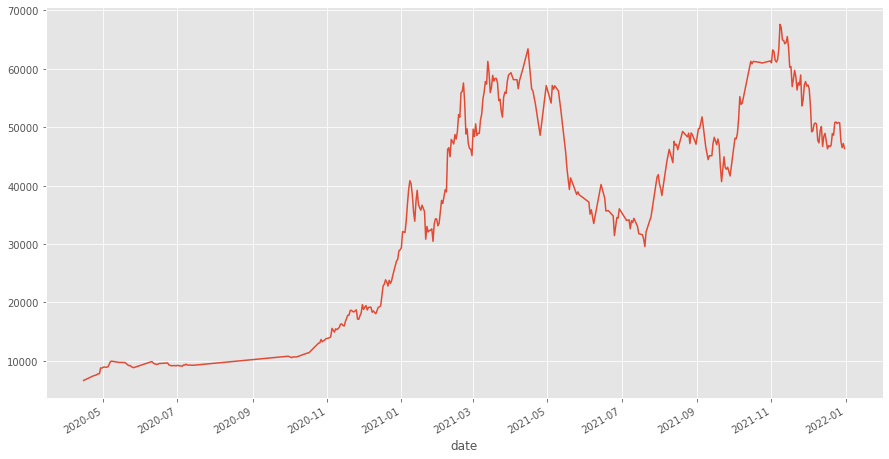

In [39]:
train_close.plot(figsize=(15,8))

### 2. Train RL model

100%|██████████| 512/512 [00:05<00:00, 101.00it/s]


Start training...


 10%|█         | 1/10 [00:02<00:19,  2.20s/it]

Evaluation after 2 episodes (321 steps) with average reward: 0.389459970250408


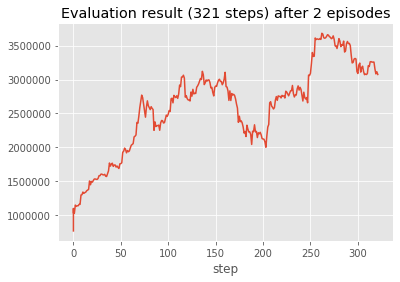

 30%|███       | 3/10 [00:07<00:18,  2.65s/it]

Evaluation after 4 episodes (321 steps) with average reward: 0.3987716627128846


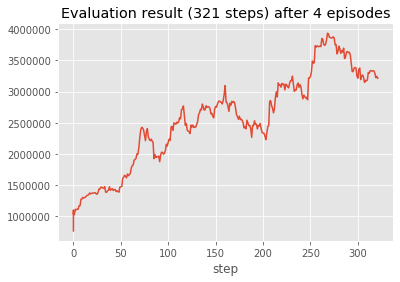

 50%|█████     | 5/10 [00:11<00:11,  2.23s/it]

Evaluation after 6 episodes (321 steps) with average reward: 0.3540197938641782


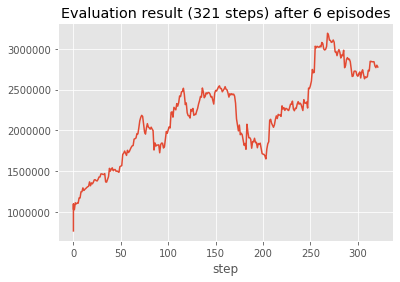

 70%|███████   | 7/10 [00:15<00:06,  2.13s/it]

Evaluation after 8 episodes (321 steps) with average reward: 0.4592763720539297


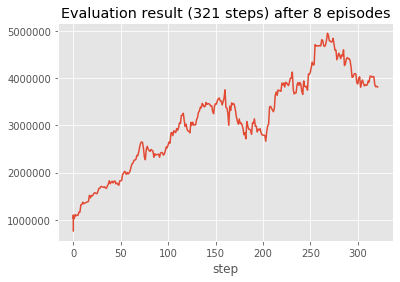

 90%|█████████ | 9/10 [00:20<00:01,  1.94s/it]

Evaluation after 10 episodes (321 steps) with average reward: 0.2810563788291409


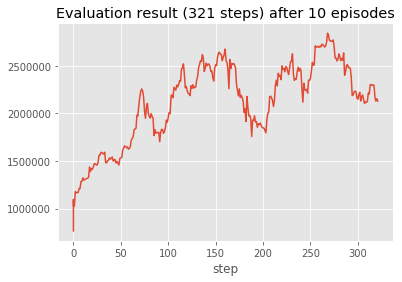

100%|██████████| 10/10 [00:23<00:00,  2.38s/it]


In [34]:
with tf.device('/CPU:0'):
    myAgent = DQNAgent(train_env, policy_network=network)
    myAgent.train(n_episodes=n_episodes,
                  save_every=save_every,
                  save_path=save_path,
                  step_verbose=step_verbose,
                  episode_verbose=episode_verbose,
                  evaluate_every_n_episode=evaluate_every_n_episode,
                  save_episodic_performance=save_episodic_performance,
                  **agent_spec)

In [35]:
#myAgent.env = test_env
#myAgent.test(start_step = 40, n_steps=100)

In [15]:
#myAgent.get_action(train_env.reset())

array([0], dtype=int64)